<a href="https://colab.research.google.com/github/FrancoPalavicinoG/cellia/blob/main/notebooks/06_baseline_model_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load Train, Val & Test Datatsets from Google Drive

Mount Drive

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import libraries

In [25]:
# Core
import pandas as pd
import numpy as np

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

# Metrics
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, classification_report

# Explainability
import shap
import matplotlib.pyplot as plt
import seaborn as sns

Load Datasets

In [26]:
input_path = "/content/drive/MyDrive/cellia_drive/Datasets/"

Load features

In [27]:
X_train = pd.read_csv(input_path + "X_train_res.csv")
X_val   = pd.read_csv(input_path + "X_val_res.csv")
X_test  = pd.read_csv(input_path + "X_test_res.csv")

Load labels

In [28]:
y_train = pd.read_csv(input_path + "y_train_res.csv").squeeze()
y_val   = pd.read_csv(input_path + "y_val_res.csv").squeeze()
y_test  = pd.read_csv(input_path + "y_test_res.csv").squeeze()

In [29]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(897, 15) (897,)
(782, 15) (782,)
(783, 15) (783,)


### Load models

In [30]:
import joblib

models_files = {
    "Logistic_Regression": "/content/drive/MyDrive/cellia_drive/Models/Logistic Regression.joblib",
    "Random_Forest": "/content/drive/MyDrive/cellia_drive/Models/Random Forest.joblib",
    "LightGBM": "/content/drive/MyDrive/cellia_drive/Models/LightGBM.joblib"
}

loaded_models = {name: joblib.load(path) for name, path in models_files.items()}

### Prediction Examples

In [31]:
for name, model in loaded_models.items():
    y_pred = model.predict(X_test)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))


=== Logistic_Regression ===
              precision    recall  f1-score   support

           0       0.97      0.76      0.85       706
           1       0.26      0.78      0.39        77

    accuracy                           0.76       783
   macro avg       0.62      0.77      0.62       783
weighted avg       0.90      0.76      0.81       783


=== Random_Forest ===
              precision    recall  f1-score   support

           0       0.96      0.79      0.87       706
           1       0.27      0.73      0.40        77

    accuracy                           0.78       783
   macro avg       0.62      0.76      0.63       783
weighted avg       0.90      0.78      0.82       783


=== LightGBM ===
              precision    recall  f1-score   support

           0       0.96      0.77      0.85       706
           1       0.25      0.70      0.37        77

    accuracy                           0.76       783
   macro avg       0.60      0.74      0.61       783
weig

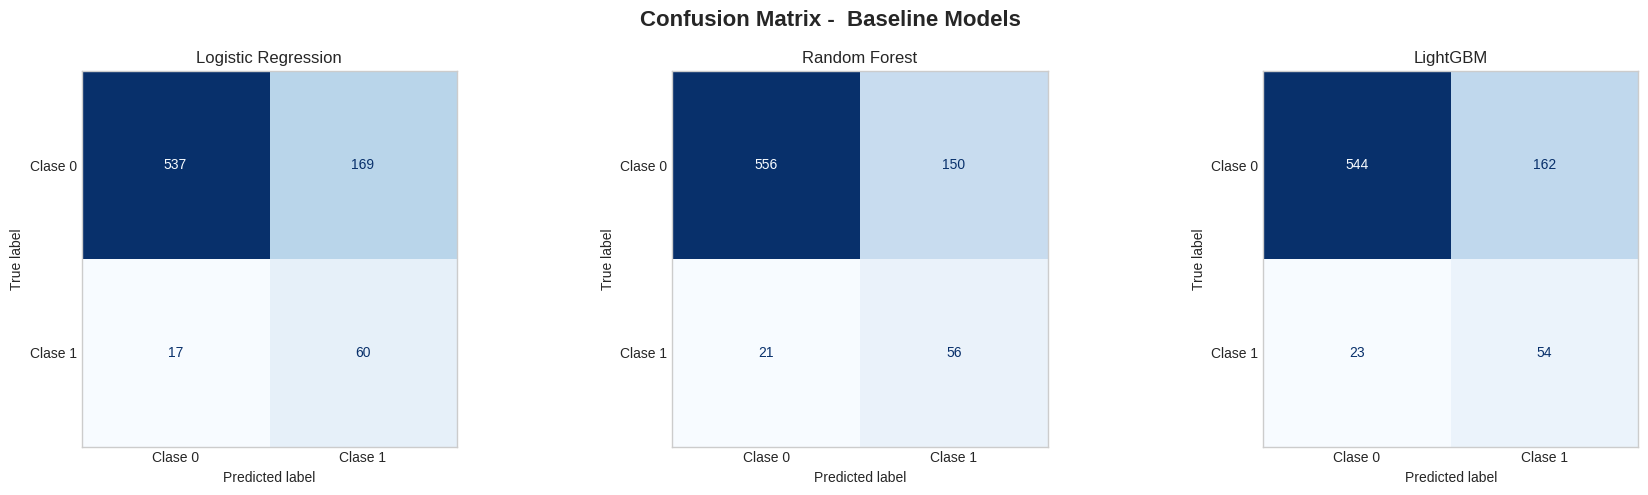

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Configurar estilo
plt.style.use("seaborn-v0_8-whitegrid")

models = {
    "Logistic Regression": loaded_models["Logistic_Regression"],
    "Random Forest": loaded_models["Random_Forest"],
    "LightGBM": loaded_models["LightGBM"]
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Clase 0", "Clase 1"])
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(name)
    ax.grid(False)

plt.suptitle("Confusion Matrix -  Baseline Models", fontsize=16, weight="bold")
plt.tight_layout()
plt.show()

### Explainability (XAI)

In [33]:
!pip install shap --upgrade

In [34]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Global Explainability


=== Logistic_Regression - Global Explainability ===


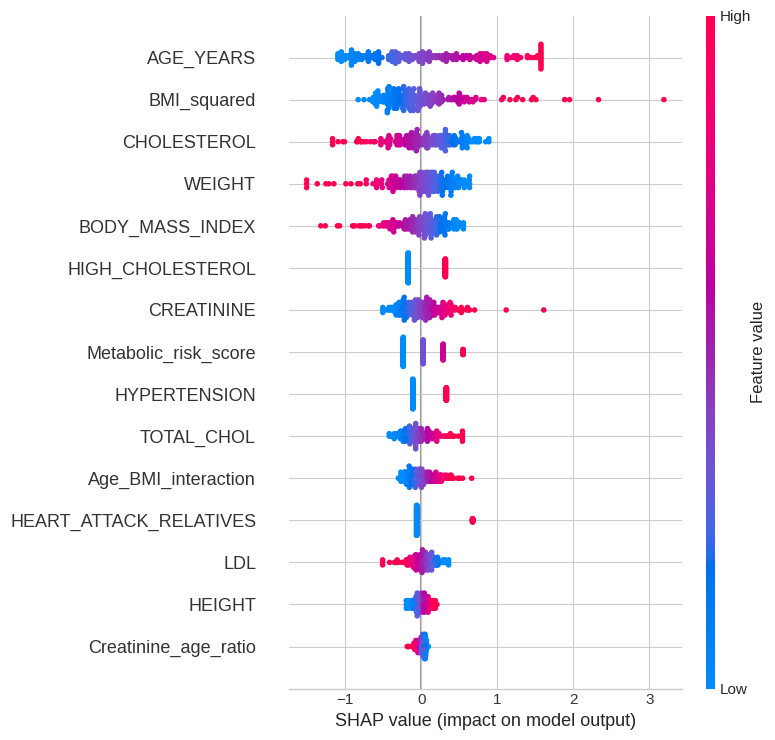


=== Random_Forest - Global Explainability ===


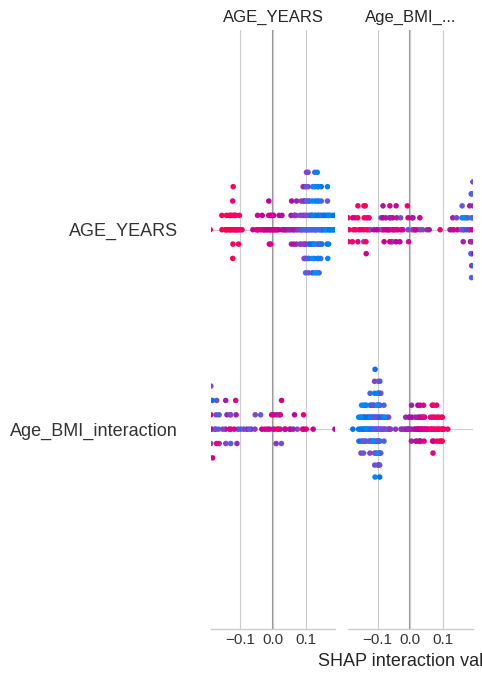


=== LightGBM - Global Explainability ===


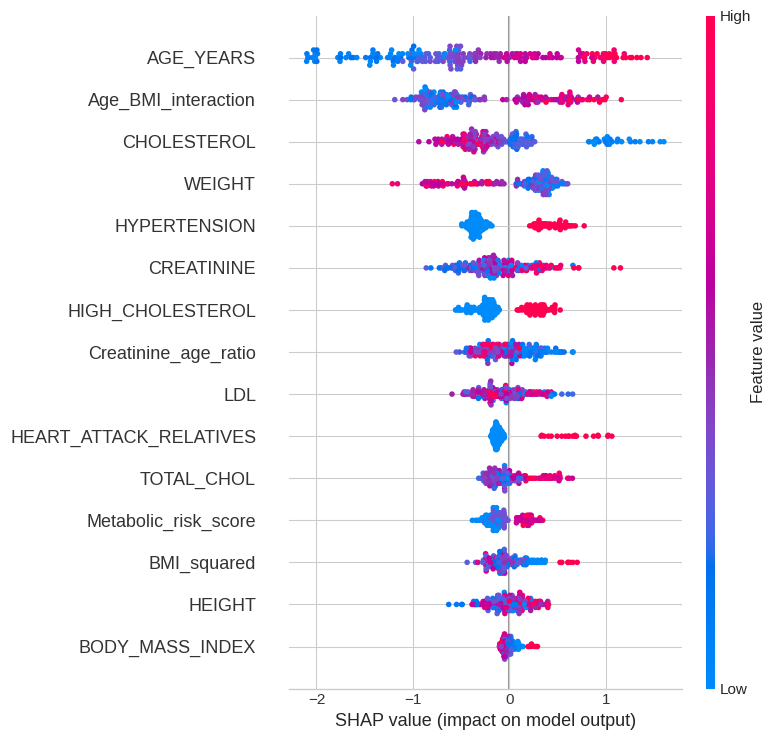

In [35]:
X_sample = X_test.sample(200, random_state=42)

for name, model in loaded_models.items():
    print(f"\n=== {name} - Global Explainability ===")

    # Create explainer
    if name == "Logistic_Regression":
        explainer = shap.Explainer(model, X_sample)
    else:  # RandomForest o LightGBM
        explainer = shap.TreeExplainer(model)

    # Obtain SHAP values
    shap_values = explainer(X_sample)

    # Summary plot
    shap.summary_plot(shap_values, X_sample, show=True)

Local Explainability


=== Logistic_Regression - Local Explainability ===

Sample index: 0


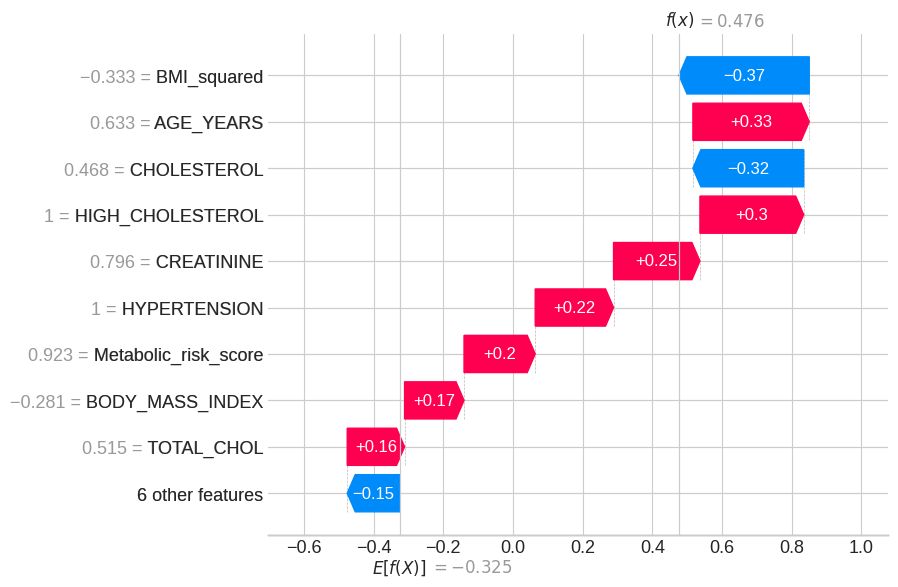


Sample index: 10


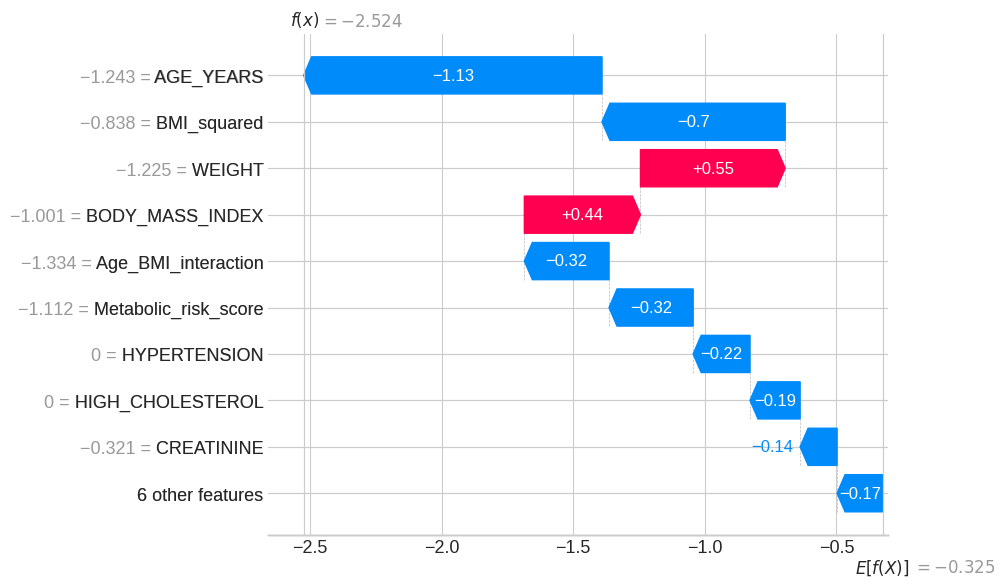


Sample index: 25


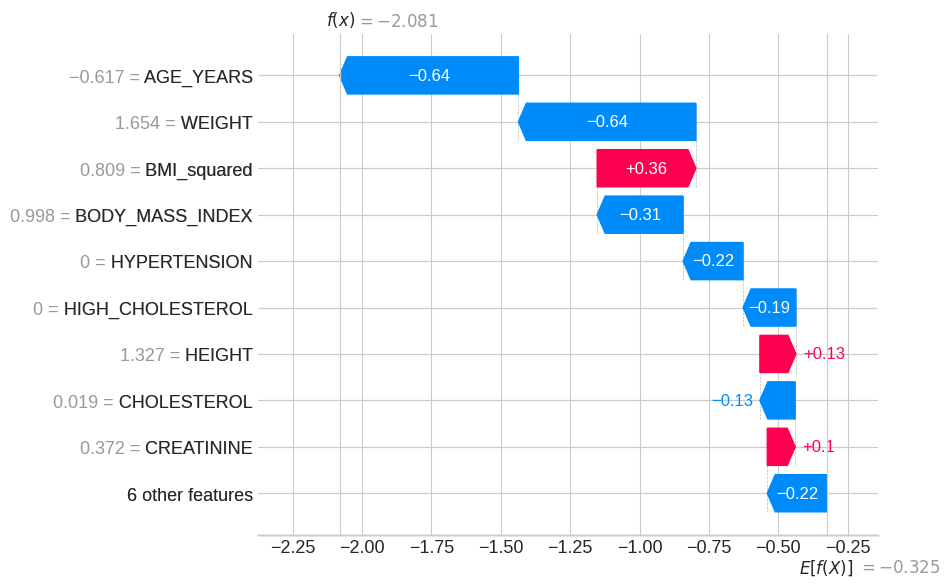


=== Random_Forest - Local Explainability ===

Sample index: 0


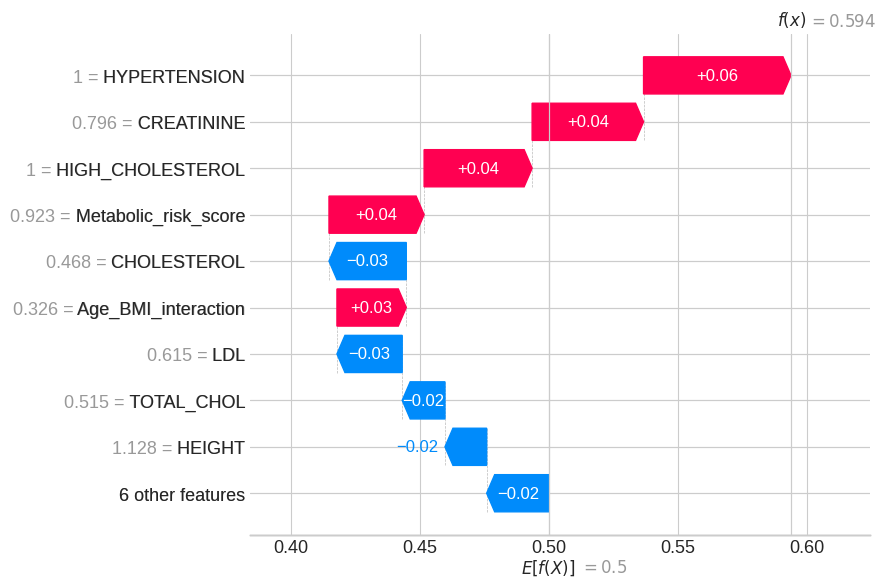


Sample index: 10


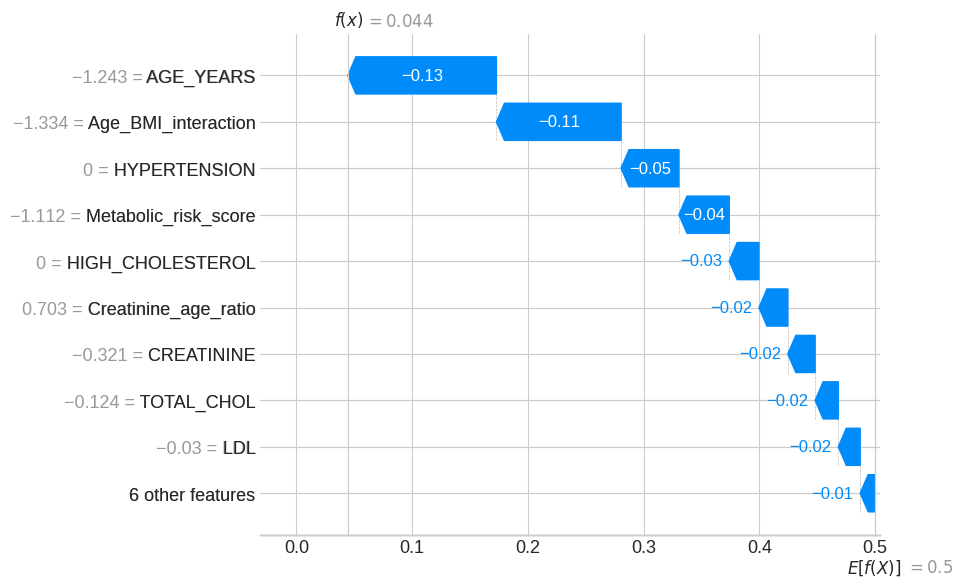


Sample index: 25


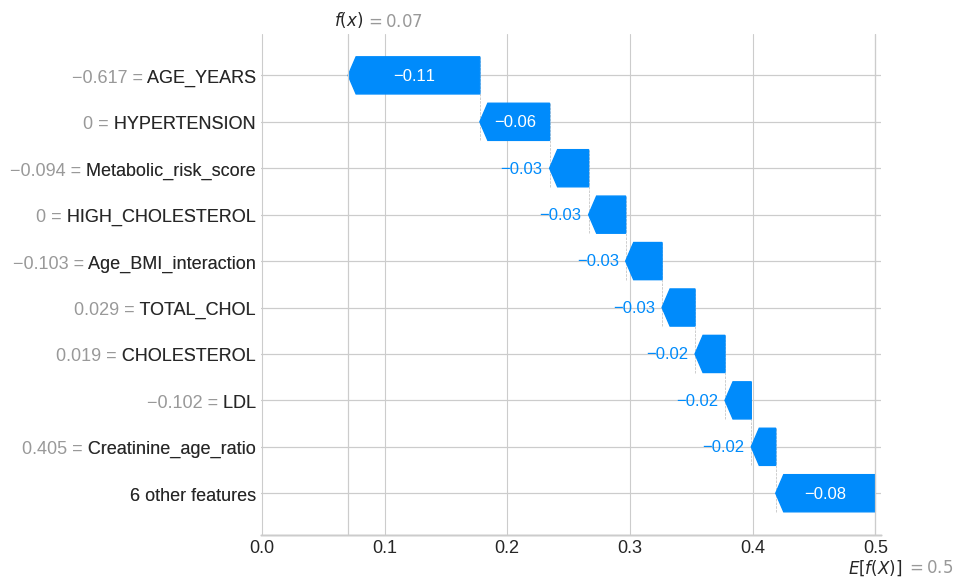


=== LightGBM - Local Explainability ===

Sample index: 0


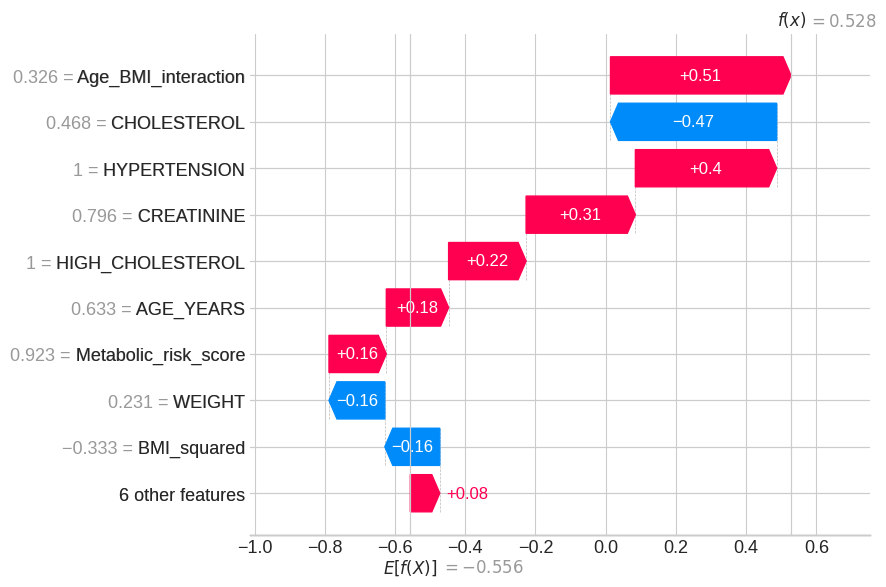


Sample index: 10


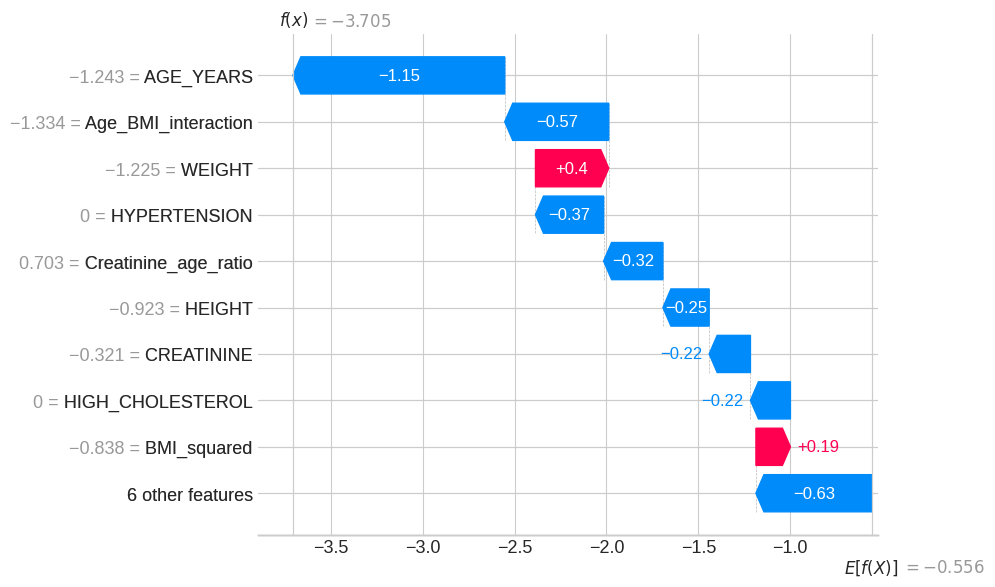


Sample index: 25


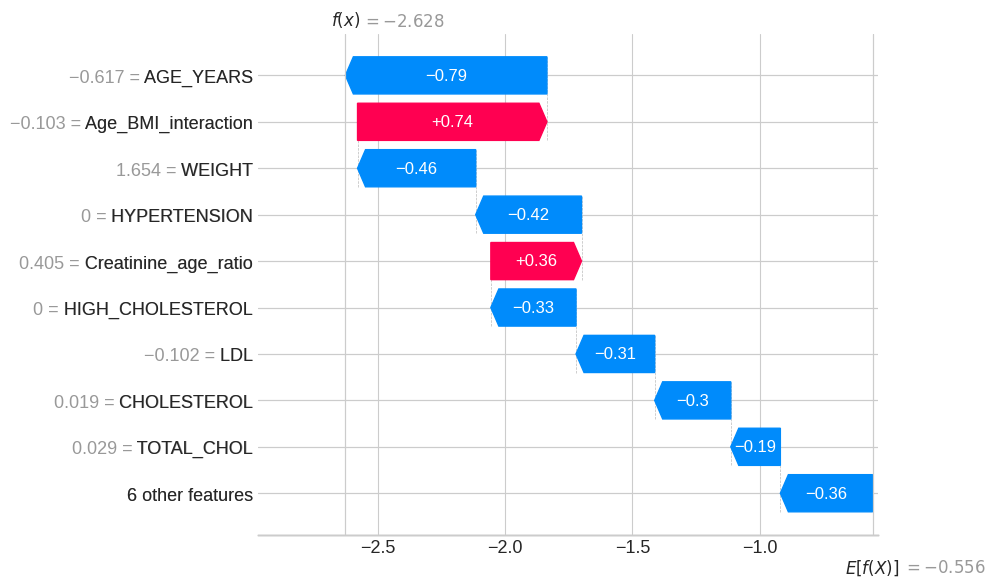

In [36]:
example_indices = [0, 10, 25]

for name, model in loaded_models.items():
    print(f"\n=== {name} - Local Explainability ===")

    # Logistic Regression
    if name == "Logistic_Regression":
        explainer = shap.Explainer(model, X_train)
        for i in example_indices:
            x_i = X_test.iloc[i:i+1]
            shap_values = explainer(x_i)
            print(f"\nSample index: {i}")
            shap.plots.waterfall(shap_values[0])
            plt.close()

    # Tree-based models (RandomForest, LightGBM)
    else:
        explainer = shap.TreeExplainer(model)
        for i in example_indices:
            x_i = X_test.iloc[i:i+1]
            shap_values = explainer(x_i)

            # RandomForest (sklearn) -> shape 3D
            if len(shap_values.values.shape) == 3:

                shap_exp_class1 = shap.Explanation(
                    values=shap_values.values[0,:,1],
                    base_values=shap_values.base_values[0,1],
                    data=x_i.values[0],
                    feature_names=x_i.columns.tolist()
                )
            else:
                # LightGBM -> shape 2D
                shap_exp_class1 = shap.Explanation(
                    values=shap_values.values[0],
                    base_values=shap_values.base_values[0],
                    data=x_i.values[0],
                    feature_names=x_i.columns.tolist()
                )

            print(f"\nSample index: {i}")
            shap.plots.waterfall(shap_exp_class1)
            plt.close()

Comparison of Feature Importance by Model

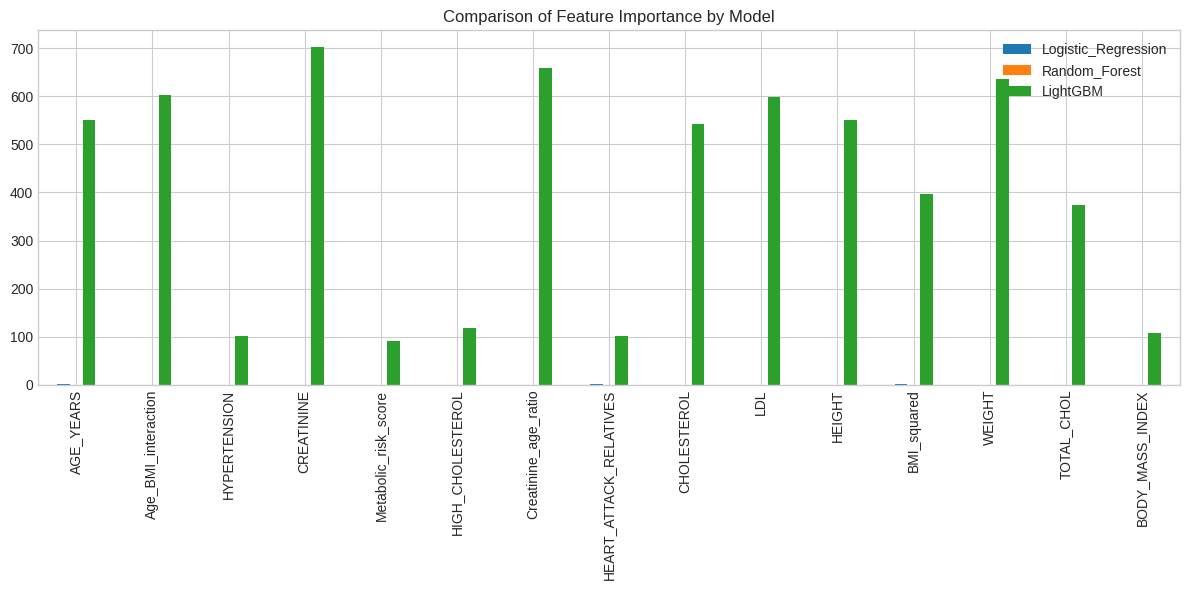

In [37]:
feature_importances = {}

for name, model in loaded_models.items():
    if hasattr(model, "feature_importances_"):  # RF, LGBM
        feature_importances[name] = model.feature_importances_
    elif hasattr(model, "coef_"):  # Logistic Regression
        feature_importances[name] = np.abs(model.coef_[0])

fi_df = pd.DataFrame(feature_importances, index=X_train.columns)
fi_df.plot.bar(figsize=(12,6))
plt.title("Comparison of Feature Importance by Model")
plt.tight_layout()
plt.show()